# Bayesian moderation analysis in PyMC3
**Author:** [Ben Vincent](https://github.com/drbenvincent)

This notebook provides an example of how to conduct a Bayesian [moderation analysis](https://en.wikipedia.org/wiki/Moderation_(statistics)). Note that this is _not_ mediation analysis, which is different.

**NOTE:** Priors in the PyMC3 model need to be updated to fit your particular situation. This is especially the case for the moderation term $\beta_2$.

## The moderation model

A 'full' moderation model defines an outcome variable $y$ as:

$$
y = \mathrm{Normal}(\beta_0 + (\beta_1 \cdot x) + (\beta_2 \cdot x \cdot moderator) + (\beta_3 \cdot moderator), \sigma^2)
$$

Where $x$ and $moderator$ are your observed data, and the following are the model parameters:
- $\beta_0$ is the intercept
- $\beta_1$ is the rate at which $y$ increases per unit of $x$. If $\beta_1>0$ then we have a main effect of $x$. 
- $\beta_2$ is the coefficient for the moderation term $x \cdot moderator$.
- $\beta_3$ is the way in which y increases as $moderator$ increases. If $\beta_3>0$ then we have a main effect of $moderator$. 
- $\sigma$ is the standard deviation of the observation noise

Optional: If you want to use autoformatter, then 

    pip install nb-black

In [1]:
%load_ext lab_black

In [2]:
import numpy as np
import pandas as pd

# plotting
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.rcParams.update({"font.size": 14})

import pymc3 as pm
import arviz as az

print(f"Running on PyMC3 v{pm.__version__}")

Running on PyMC3 v3.7


## Define options

In [3]:
SEED = 123

N = 500

# define parameters
β0, β1, β2, β3, σ = 0.5, 1, 0.7, 3, 1
params = {"β0": β0, "β1": β1, "β2": β2, "β3": β3, "σ": σ}

n_samples = 1_000

sample_options = {
    "tune": 1_000,
    "draws": n_samples,
    "chains": 2,
    "cores": 2,
    "nuts_kwargs": {"target_accept": 0.95},
    "random_seed": SEED,
}

np.random.seed(SEED)

cmap = plt.cm.get_cmap("Spectral")

## Create synthetic dataset

In [4]:
def make_data():
    x = np.random.randn(N)
    moderator = np.random.randn(N)
    μ = β0 + β1 * x + β2 * x * moderator + β3 * moderator
    ϵ = np.random.randn(N) * σ
    y = μ + ϵ
    return x, moderator, y


x, moderator, y = make_data()

## Plot data and true model

Set up `ScalarMappable` so we can access colormap across both scatter and lines
We can use:
- `scalarMap.cmap` to use as a colormap, and
- `scalarMap.to_rgba(moderator_value)` to grab a colour for a given moderator value

In [5]:
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

scalarMap = ScalarMappable(
    norm=Normalize(vmin=np.min(moderator), vmax=np.max(moderator)), cmap="viridis"
)

Text(0.5, 1.0, 'Data and true model')

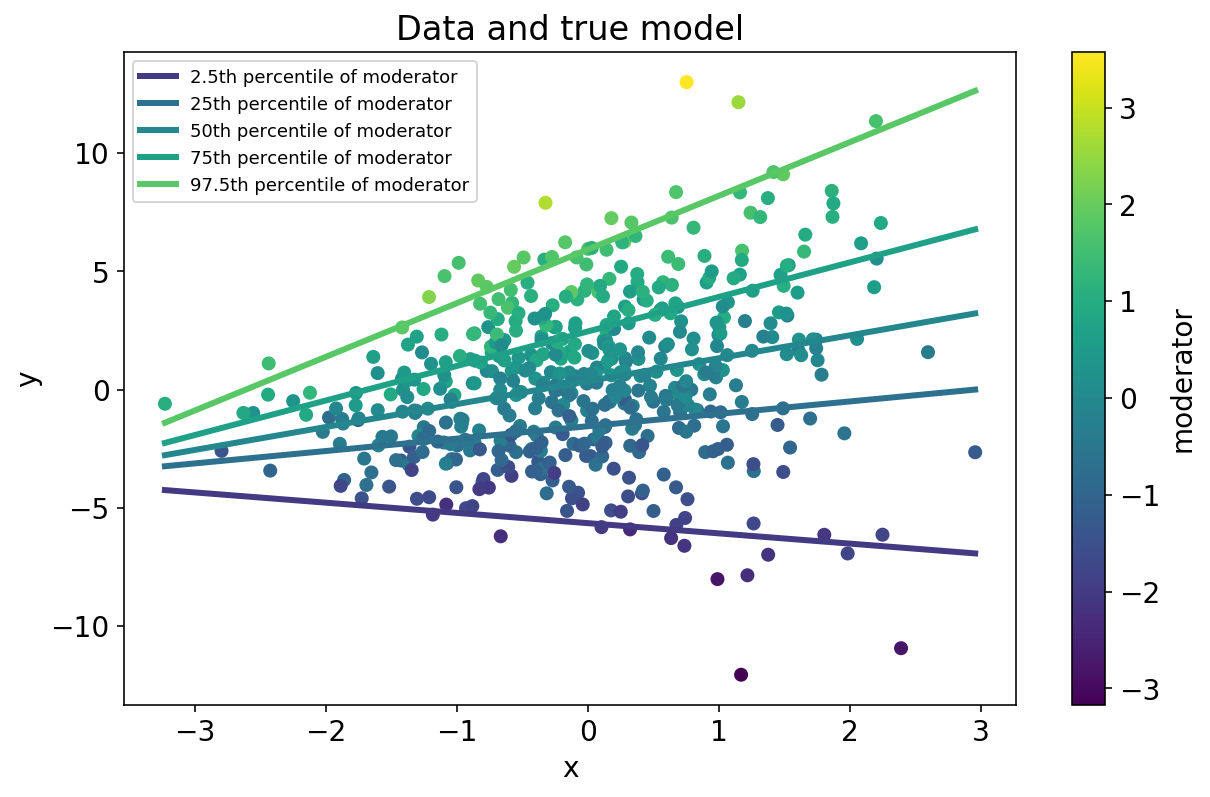

In [6]:
def plot_data(x, moderator, y, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1)
    else:
        fig = plt.gcf()

    h = ax.scatter(x, y, c=moderator, cmap=scalarMap.cmap)
    ax.set(xlabel="x", ylabel="y")
    # colourbar for moderator
    cbar = fig.colorbar(h)
    cbar.ax.set_ylabel("moderator")
    return ax


def plot_true(ax):
    _x = np.linspace(np.min(x), np.max(x), 10)
    moderator_percentiles = [2.5, 25, 50, 75, 97.5]
    m_levels = np.percentile(moderator, moderator_percentiles)
    for p, m in zip(moderator_percentiles, m_levels):
        μ = β0 + β1 * _x + β2 * _x * m + β3 * m
        ax.plot(
            _x, μ, lw=3, label=f"{p}th percentile of moderator", c=scalarMap.to_rgba(m)
        )
    ax.legend(fontsize=9)


fig, ax = plt.subplots(figsize=(10, 6))
ax = plot_data(x, moderator, y, ax=ax)
plot_true(ax)
ax.set_title("Data and true model")

## Make model

In [7]:
def bayesian_moderation(y, x, m):
    """Conduct simple Bayesian moderation. 
    Returns the model and the trace."""

    print("WARNING: Priors must be updated to suit your speicific data context")

    with pm.Model() as model:

        β0 = pm.Normal("β0", mu=0, sd=1)
        β1 = pm.Normal("β1", mu=0, sd=1)
        β2 = pm.Normal("β2", mu=0, sd=1)
        β3 = pm.Normal("β3", mu=0, sd=1)
        σ = pm.HalfCauchy("σ", 1)

        y = pm.Normal("y", mu=β0 + (β1 * x) + (β2 * x * m) + (β3 * m), sd=σ, observed=y)

    with model:
        trace = pm.sample(**sample_options)

    return model, trace

In [8]:
model, trace = bayesian_moderation(y, x, moderator)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, β3, β2, β1, β0]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:03<00:00, 1122.05draws/s]


Check the trace if you like, using:

    pm.traceplot(trace)

## Plot posterior over parameters.

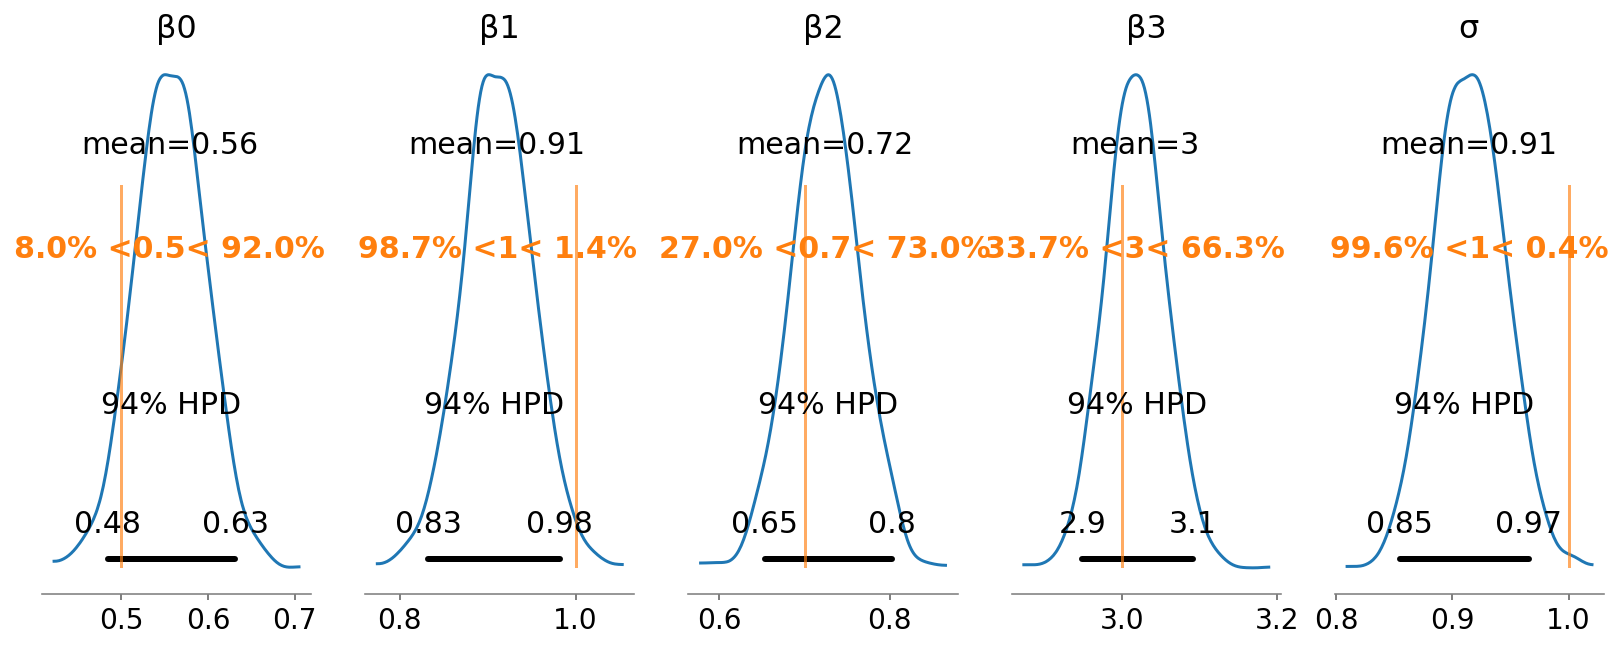

In [9]:
def plot_posteriors():
    fig, ax = plt.subplots(1, 5, figsize=(14, 5))
    for i, (key, val) in enumerate(params.items()):
        az.plot_posterior(trace, var_names=key, ax=ax[i], ref_val=val)


plot_posteriors()

## Posterior prediction

In [10]:
def posterior_prediction_plot(
    trace, y, x, moderator, ax=None, percentile_list=[2.5, 25, 50, 75, 97.5]
):
    """Plot posterior predicted `y` for the defined moderator percentiles"""
    if ax is None:
        fig, ax = plt.subplots(1, 1)

    # PLOT POSTERIOR PREDICTED `y` FOR DEFINED MODERATOR LEVELS
    xi = np.linspace(np.min(x), np.max(x), 20)
    m_levels = np.percentile(moderator, percentile_list)

    for p, m in zip(percentile_list, m_levels):
        β0 = np.expand_dims(trace["β0"], axis=1)
        β1 = np.expand_dims(trace["β1"], axis=1)
        β2 = np.expand_dims(trace["β2"], axis=1)
        β3 = np.expand_dims(trace["β3"], axis=1)
        _y = β0 + β1 * xi + β2 * xi * m + β3 * m
        region = np.percentile(_y, [2.5, 50, 95], axis=0)

        ax.fill_between(
            xi,
            region[0, :],
            region[2, :],
            alpha=0.2,
            color=scalarMap.to_rgba(m),
            edgecolor="w",
        )
        ax.plot(
            xi,
            region[1, :],
            color=scalarMap.to_rgba(m),
            linewidth=2,
            label=f"{p}th percentile of moderator",
        )

    ax.legend(fontsize=9)

    ax.set(xlabel="x", ylabel="y")
    return ax

Text(0.5, 1.0, 'Data and posterior prediction')

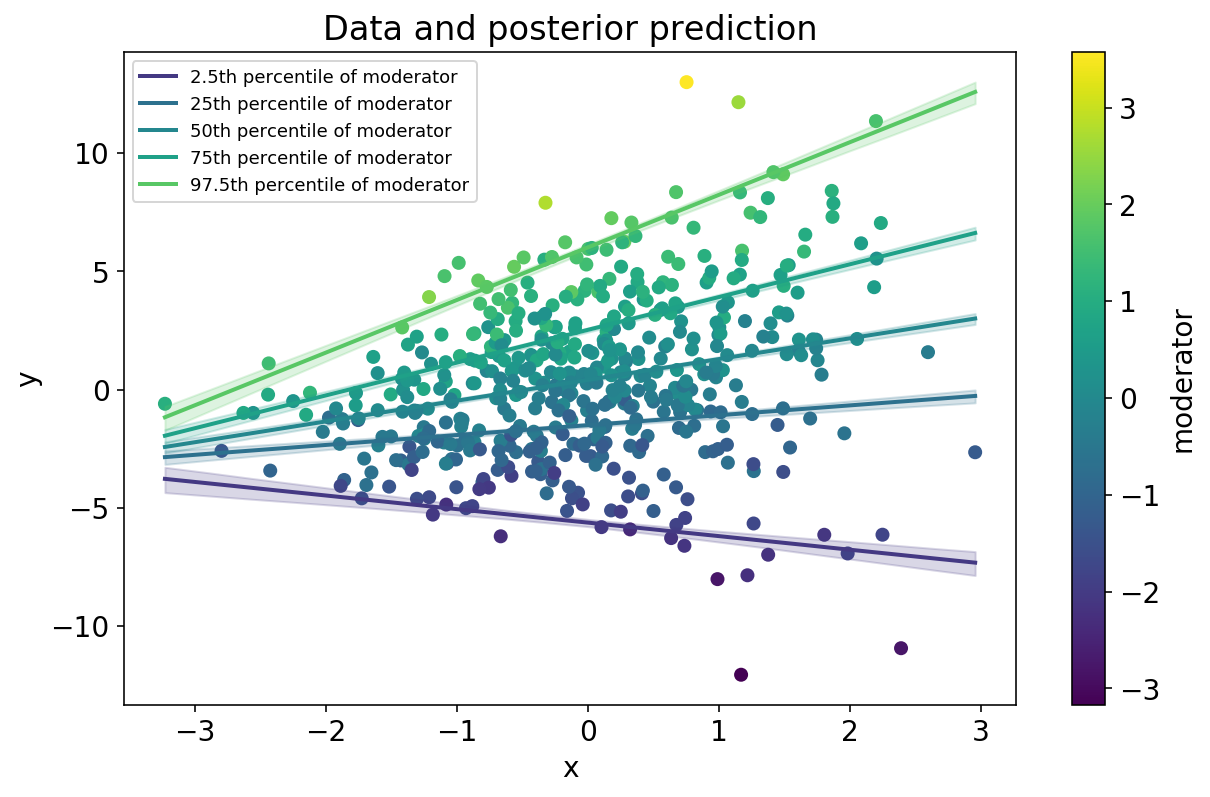

In [11]:
fig, ax = plt.subplots(figsize=(10, 6))
plot_data(x, moderator, y, ax=ax)
posterior_prediction_plot(trace, y, x, moderator, ax=ax)
ax.set_title("Data and posterior prediction")